Found 287 files belonging to 5 classes.
Found 113 files belonging to 5 classes.
Found 172 files belonging to 5 classes.


2025-03-26 20:15:26.650789: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-26 20:15:26.650818: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-26 20:15:26.650822: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-26 20:15:26.651173: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-26 20:15:26.651190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-26 20:15:27.084107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class Weights: {0: 2.05, 1: 1.1254901960784314, 2: 1.0629629629629629, 3: 1.1254901960784314, 4: 0.5572815533980583}
Epoch 1/20


2025-03-26 20:15:29.685809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.3101 - loss: 0.3021
Epoch 1: val_loss improved from inf to 0.13772, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/efficientNet_OCTID_best.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3177 - loss: 0.2985 - val_accuracy: 0.7080 - val_loss: 0.1377 - learning_rate: 3.0000e-04
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.6149 - loss: 0.1796
Epoch 2: val_loss improved from 0.13772 to 0.10380, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/efficientNet_OCTID_best.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 627ms/step - accuracy: 0.6137 - loss: 0.1777 - val_accuracy: 0.7257 - val_loss: 0.1038 - learning_rate: 2.9816e-04
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7103 - loss: 0.1140
Epoch 3: val_loss improved from 0.10380 to 0.09824, saving model to /Users/mananmathu

2025-03-26 20:34:10.468479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


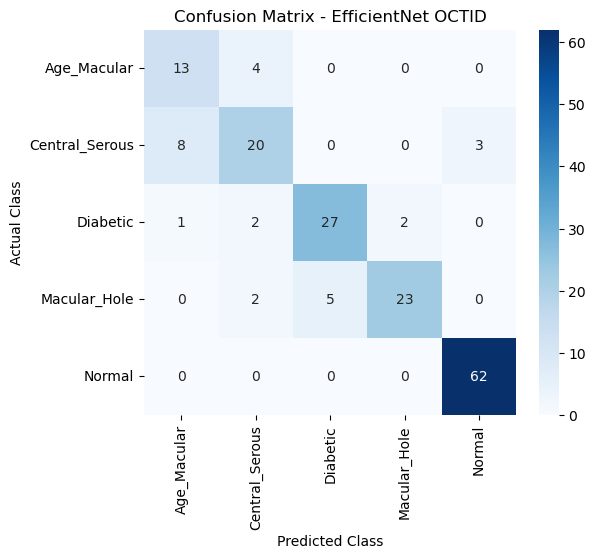

Classification Report:
                 precision    recall  f1-score   support

   Age_Macular       0.59      0.76      0.67        17
Central_Serous       0.71      0.65      0.68        31
      Diabetic       0.84      0.84      0.84        32
  Macular_Hole       0.92      0.77      0.84        30
        Normal       0.95      1.00      0.98        62

      accuracy                           0.84       172
     macro avg       0.80      0.80      0.80       172
  weighted avg       0.85      0.84      0.84       172

✅ Results saved to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/results/efficientNet_OCTID.xlsx


In [1]:
# DATASET = OCTID
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# ✅ **Disable GPU if Needed**
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Enable Mixed Precision for Faster Training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Paths and Constants
dataset_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/OCTID"
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Test")

image_size = 224  # EfficientNet requires 224x224 images
batch_size = 32  # Increased for faster training
num_classes = 5  # Multi-class classification

# Use One-Hot Encoding (Fix for Label Shape Error)
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir, label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size)
)
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir, label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size)
)
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir, label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size), shuffle=False
)

# Compute Class Weights for Imbalanced Dataset
labels = np.concatenate([y.numpy() for _, y in train_data])
class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=np.argmax(labels, axis=1))
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class Weights: {class_weight_dict}")

# Load Pretrained EfficientNet
base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False  # Freeze initially

# Define Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")  # Multi-class classification
])

# Compile with Categorical Focal Loss
model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss=CategoricalFocalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Cosine Annealing LR Scheduler
def cosine_annealing(epoch, lr):
    return 1e-6 + (3e-4 - 1e-6) * (1 + np.cos(np.pi * epoch / 20)) / 2

# Callbacks
model_save_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/efficientNet_OCTID_best.keras"
callbacks = [
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    CSVLogger("/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/training/efficientNet_OCTID.csv", append=True),
    tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
]

# Train Model
history = model.fit(train_data, validation_data=val_data, epochs=20, class_weight=class_weight_dict, callbacks=callbacks)

# Fine-Tuning Step
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss=CategoricalFocalCrossentropy(), metrics=["accuracy"])
history_finetune = model.fit(train_data, validation_data=val_data, epochs=10, class_weight=class_weight_dict, callbacks=callbacks)

# Load Best Model
model = load_model(model_save_path, custom_objects={"CategoricalFocalCrossentropy": CategoricalFocalCrossentropy()})
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate Predictions
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y.numpy() for _, y in test_data])

# Confusion Matrix & Report
cm = confusion_matrix(np.argmax(true_labels, axis=1), predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_data.class_names, yticklabels=train_data.class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix - EfficientNet OCTID")
plt.show()

report = classification_report(np.argmax(true_labels, axis=1), predicted_classes, target_names=train_data.class_names, output_dict=True)
print("Classification Report:\n", classification_report(np.argmax(true_labels, axis=1), predicted_classes, target_names=train_data.class_names))

# Save Results to Excel
excel_file = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/results/efficientNet_OCTID.xlsx"
results_df = pd.DataFrame({
    "Dataset": ["OCTID"],
    "Model": ["EfficientNet"],
    "Test Accuracy": [test_accuracy],
    "Test Loss": [test_loss],
    "Precision": [report["weighted avg"]["precision"]],
    "Recall": [report["weighted avg"]["recall"]],
    "F1-Score": [report["weighted avg"]["f1-score"]]
})

try:
    if os.path.exists(excel_file):
        existing_df = pd.read_excel(excel_file)
        results_df = pd.concat([existing_df, results_df], ignore_index=True)
except FileNotFoundError:
    pass  # If the file does not exist, it will be created

results_df.to_excel(excel_file, index=False)
print(f"✅ Results saved to {excel_file}")

Found 1095 files belonging to 2 classes.


2025-03-28 16:30:51.164130: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-28 16:30:51.164155: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-28 16:30:51.164158: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-28 16:30:51.164777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-28 16:30:51.164805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 451 files belonging to 2 classes.
Found 644 files belonging to 2 classes.


2025-03-28 16:30:52.333055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class Weights: {0: 0.6441176470588236, 1: 2.2346938775510203}
Epoch 1/20


2025-03-28 16:30:55.425017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5139 - loss: 0.2032
Epoch 1: val_loss improved from inf to 0.17006, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/efficientNet_OCTDL_best.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.5139 - loss: 0.2032 - val_accuracy: 0.7761 - val_loss: 0.1701 - learning_rate: 1.0000e-04
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5162 - loss: 0.1936
Epoch 2: val_loss did not improve from 0.17006
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.5156 - loss: 0.1937 - val_accuracy: 0.2239 - val_loss: 0.1777 - learning_rate: 9.9391e-05
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5508 - loss: 0.1929
Epoch 3: val_loss did not improve from 0.17006
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.5496 - loss: 0.1930 - val_accuracy: 0.2239 - val_loss: 0.1774 - learning_rate: 9.7577e-05
Epoch 4/20
35/35 ━━━━━━━━━━━━━

2025-03-28 16:41:23.936519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


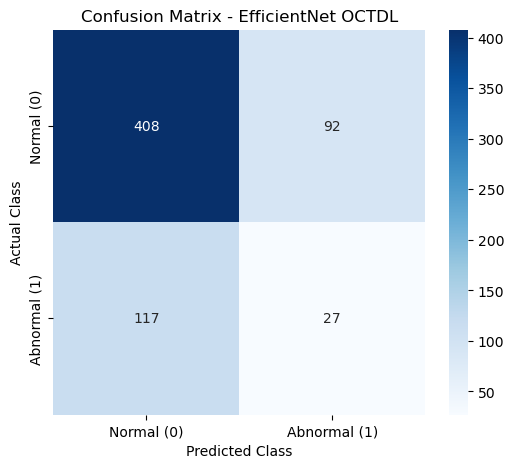

Classification Report:
               precision    recall  f1-score   support

      Normal       0.78      0.82      0.80       500
    Abnormal       0.23      0.19      0.21       144

    accuracy                           0.68       644
   macro avg       0.50      0.50      0.50       644
weighted avg       0.65      0.68      0.66       644

✅ Results saved to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/results/efficientNet_OCTDL.xlsx


In [1]:
# **EfficientNetV2B0 Model for OCTDL Dataset (Optimized)**
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.losses import BinaryFocalCrossentropy

# ✅ **Disable GPU if Needed**
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ✅ **Paths**
base_log_dir = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs"
model_save_path = os.path.join(base_log_dir, "models", "efficientNet_OCTDL_best.keras")
training_log_path = os.path.join(base_log_dir, "training", "efficientNet_OCTDL.csv")
results_excel_path = os.path.join(base_log_dir, "results", "efficientNet_OCTDL.xlsx")

dataset_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/OCTDL"
train_dir, val_dir, test_dir = [os.path.join(dataset_path, x) for x in ["Train", "Validation", "Test"]]

# ✅ **Hyperparameters**
image_size = 224
batch_size = 32  # Increased for Stability & Speed
num_classes = 2
epochs = 20  # Reduce for faster training

# ✅ **Create `tf.data` Input Pipeline**
def preprocess_image(image, label):
    image = tf.image.resize(image, [image_size, image_size]) / 255.0  # Normalize
    return image, label

def load_dataset(directory):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory, image_size=(image_size, image_size), batch_size=batch_size, label_mode="binary"
    ).map(preprocess_image).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

train_data = load_dataset(train_dir)
val_data = load_dataset(val_dir)
test_data = load_dataset(test_dir)

# ✅ **Compute Class Weights (Fixed)**
labels = np.concatenate([y.numpy().flatten() for _, y in train_data])  # Flatten ensures 1D
unique_classes = np.unique(labels)  # Keep as NumPy array

class_weights = compute_class_weight("balanced", classes=unique_classes, y=labels)
class_weight_dict = {int(cls): float(weight) for cls, weight in zip(unique_classes, class_weights)}

print(f"Class Weights: {class_weight_dict}")

# ✅ **Build EfficientNetV2B0 Model**
base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False  # Freeze Base Model Initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # Binary Classification
])

# ✅ **Cosine Annealing Learning Rate Scheduler**
def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    min_lr = 1e-6
    return min_lr + (initial_lr - min_lr) * (1 + np.cos(np.pi * epoch / epochs)) / 2

# ✅ **Compile Model**
model.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryFocalCrossentropy(), metrics=["accuracy"])

# ✅ **Callbacks**
callbacks = [
    ModelCheckpoint(model_save_path, monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True),
    CSVLogger(training_log_path, append=True),
    LearningRateScheduler(cosine_annealing)
]

# ✅ **Train Model**
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# ✅ **Fine-Tuning**
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss=BinaryFocalCrossentropy(), metrics=["accuracy"])

fine_tune_epochs = 5
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=fine_tune_epochs,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# ✅ **Save Final Model**
model.save(model_save_path)
print("Model saved successfully!")

# ✅ **Load Model for Evaluation (Fixed)**
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({"BinaryFocalCrossentropy": BinaryFocalCrossentropy})
loaded_model = load_model(model_save_path)
print("Model loaded successfully!")

# ✅ **Evaluate on Test Set**
test_loss, test_accuracy = loaded_model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# ✅ **Generate Predictions**
predictions = loaded_model.predict(test_data)
binary_predictions = (predictions > 0.5).astype(int).flatten()

# ✅ **Confusion Matrix & Classification Report**
true_labels = np.concatenate([y.numpy() for _, y in test_data])
cm = confusion_matrix(true_labels, binary_predictions)

# ✅ **Plot Confusion Matrix**
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal (0)", "Abnormal (1)"], yticklabels=["Normal (0)", "Abnormal (1)"])
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix - EfficientNet OCTDL")
plt.show()

# ✅ **Print Classification Report**
report = classification_report(true_labels, binary_predictions, target_names=["Normal", "Abnormal"], output_dict=True)
print("Classification Report:\n", classification_report(true_labels, binary_predictions, target_names=["Normal", "Abnormal"]))

# ✅ **Save Results to Excel**
results_df = pd.DataFrame({
    "Dataset": ["OCTDL"],
    "Model": ["EfficientNetV2B0"],
    "Test Accuracy": [test_accuracy],
    "Test Loss": [test_loss],
    "Precision": [report["weighted avg"]["precision"]],
    "Recall": [report["weighted avg"]["recall"]],
    "F1-Score": [report["weighted avg"]["f1-score"]]
})

try:
    if os.path.exists(results_excel_path):
        existing_df = pd.read_excel(results_excel_path)
        results_df = pd.concat([existing_df, results_df], ignore_index=True)
except FileNotFoundError:
    pass  # If the file does not exist, it will be created

results_df.to_excel(results_excel_path, index=False)
print(f"✅ Results saved to {results_excel_path}")